## Imports

In [41]:
import pandas as pd
import sys, os, importlib
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [42]:
pd.set_option('display.max_rows', 100)

if os.path.join('..','0_funcoes_base') not in sys.path:
    sys.path.append(os.path.join('..','0_funcoes_base')) 

df_manipulator = importlib.import_module('df_manipulator')
plot_manipulator = importlib.import_module('plot_manipulator')


## Dados de configuração

In [43]:
input_config = {
    'file': {
        'ref_dir':'../1_pre_processamento/out/',
        'filename':'4_export_lunar_20200517.csv',
        'delimiter': ';'
    }
}

output_config = {
    'file': {
        'ref_dir': './out',
        'prefix':'5_'
    }
}

## Funções

In [66]:
def get_speed_bump_window_distribution(df, mapping_window_width, mapping_window_freq, speed_bump_id, verbose=False):
    _df = df.copy()

    sb_indexes = df_manipulator.get_speed_bumps_idx(_df, speed_bump_id)

    mapping_speed_bump_timestamps = df_manipulator.get_affected_timestamps_by_speed_bumps(_df, sb_indexes, mapping_window_width=mapping_window_width, mapping_window_freq=mapping_window_freq, verbose=verbose)

    return mapping_speed_bump_timestamps

def plot_speed_bump_distribution(df, mapping_speed_bump_timestamps, speed_bump_id, columns, limit=10, backward_time=20, forward_time=5, save_figure=False):
    count_plots = 0

    previous_base_date = list(mapping_speed_bump_timestamps[speed_bump_id].keys())[0] - pd.Timedelta(minutes=10)

    for base_date in list(mapping_speed_bump_timestamps[speed_bump_id].keys()):
        elapsed_time = base_date - previous_base_date
        
        if elapsed_time.seconds < 5:
            continue

        start_date = (base_date - pd.Timedelta(seconds=backward_time)).strftime('%d/%m/%Y %H:%M:%S.%f')
        end_date   = (base_date + pd.Timedelta(seconds=forward_time)).strftime('%d/%m/%Y %H:%M:%S.%f')

        special_points = {}
        special_points[previous_base_date.strftime('%d/%m/%Y %H:%M:%S.%f')] = 'SpeedBump'
        # special_points[(mapping_speed_bump_timestamps[speed_bump_id][base_date]['new'] - pd.Timedelta(seconds=5)).strftime('%d/%m/%Y %H:%M:%S.%f')] = 'Braking'
        special_points[base_date.strftime('%d/%m/%Y %H:%M:%S.%f')] = 'SpeedBump'
        #special_points[base_date.strftime('%d/%m/%Y %H:%M:%S.%f')] = 'Old'

        plot_manipulator.plot_timeseries(df, columns, start_date, end_date, legend=columns, special_dates=special_points)
        
        if save_figure:
            formatted_start_date = (base_date - pd.Timedelta(seconds=backward_time)).strftime('%Y%m%d-%H%M%S')
            formatted_end_date   = (base_date + pd.Timedelta(seconds=forward_time)).strftime('%Y%m%d-%H%M%S')

            save_figure_name = str(speed_bump_id) + '_' + formatted_start_date + '_' + formatted_end_date + '.png'
            plt.savefig(save_figure_name, dpi=500)
        
        count_plots +=1

        previous_base_date = base_date

        if not limit or limit < 1 or count_plots >= limit:
            break

def distplot(df, tags, region_id, nrows=None, ncols=None, size=None, row_height=4):
    _df = df.copy()

    _df = _df[_df.region_id == region_id]

    ncols = ncols if ncols else 2
    nrows = nrows if nrows else int(np.ceil(len(tags)/ncols))    
    
    size = size if size else (15,nrows*row_height)
    fig, axs = plt.subplots(nrows=nrows, ncols = ncols, figsize = size)
    for i, tag in enumerate(tags):
        row = i//ncols
        col = i%ncols
        df_plt = _df[tag]
        df_plt.dropna(inplace=True)
        sns.distplot(df_plt, hist=True, rug=False, norm_hist=False, axlabel=None, label=None, ax=axs[row,col], color=None)


def scatter_hist(x, y):

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color='b')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color='skyblue')
    ax_histy.hist(y, bins=bins, color='green',orientation='horizontal')

    plt.show()




## Carrega dataframe

In [45]:
df = df_manipulator.load_dataframe(input_config['file']['filename'], input_config['file']['ref_dir'], input_config['file']['delimiter'])
df.timestamp = pd.to_datetime(df.timestamp)
df_manipulator.set_index(df, 'timestamp', True)

In [46]:
df

speed_bump_id          y         z        lat  \
timestamp                                                                
2020-05-17 20:10:49.400              0   9.188202  1.528488 -22.921991   
2020-05-17 20:10:49.500              0   9.188202  1.528488 -22.921991   
2020-05-17 20:10:49.600              0   9.365372  2.237167 -22.921991   
2020-05-17 20:10:49.700              0   9.365372  2.237167 -22.921991   
2020-05-17 20:10:49.800              0   9.743652  1.281876 -22.921991   
...                                ...        ...       ...        ...   
2020-05-17 20:35:51.100              0   9.250443  1.770294 -22.925816   
2020-05-17 20:35:51.200              0  10.105179  1.660172 -22.925816   
2020-05-17 20:35:51.300              0   9.920822  2.608276 -22.925816   
2020-05-17 20:35:51.400              0   9.523392  2.505325 -22.925816   
2020-05-17 20:35:51.500              0   8.999054  2.871628 -22.925816   

                               lng  region_id  z-mean_10  z-std_10  z-diff_5  \
timestamp                                                                      
2020-05-17 20:10:49.400 -42.473372          1   1.335992  0.416962 -0.320816   
2020-05-17 20:10:49.500 -42.473372          1   1.331444  0.414317  1.005569   
2020-05-17 20:10:49.600 -42.473372          1   1.426015  0.502685  1.448486   
2020-05-17 20:10:49.700 -42.473372          1   1.520586  0.560224  0.986404   
2020-05-17 20:10:49.800 -42.473372          1   1.468152  0.555034 -0.174789   
...                            ...        ...        ...       ...       ...   
2020-05-17 20:35:51.100 -42.484631          1   2.505797  1.961719  1.826767   
2020-05-17 20:35:51.200 -42.484631          1   2.415536  1.979490 -4.141968   
2020-05-17 20:35:51.300 -42.484631          1   2.420087  1.979918 -3.193863   
2020-05-17 20:35:51.400 -42.484631          1   2.375316  1.971573  1.259354   
2020-05-17 20:35:51.500 -42.484631          1   2.597977  1.877957  1.101334   

                         z-diff_10    z-norm  
timestamp                                     
2020-05-17 20:10:49.400  -0.045486  0.461662  
2020-05-17 20:10:49.500  -0.045486  0.475588  
2020-05-17 20:10:49.600   0.945709  1.613640  
2020-05-17 20:10:49.700   0.945709  1.279099  
2020-05-17 20:10:49.800  -0.524338 -0.335612  
...                            ...       ...  
2020-05-17 20:35:51.100  -0.660797 -0.374928  
2020-05-17 20:35:51.200  -0.902603 -0.381596  
2020-05-17 20:35:51.300   0.045502  0.095049  
2020-05-17 20:35:51.400  -0.447708  0.065942  
2020-05-17 20:35:51.500   2.226608  0.145717  

[14113 rows x 11 columns]

In [47]:
df.speed_bump_id.value_counts()

0    14068
1       45
Name: speed_bump_id, dtype: int64

# Distribuição dos eventos

Text(0.5, 1.0, 'All SpeedBumps distribution')

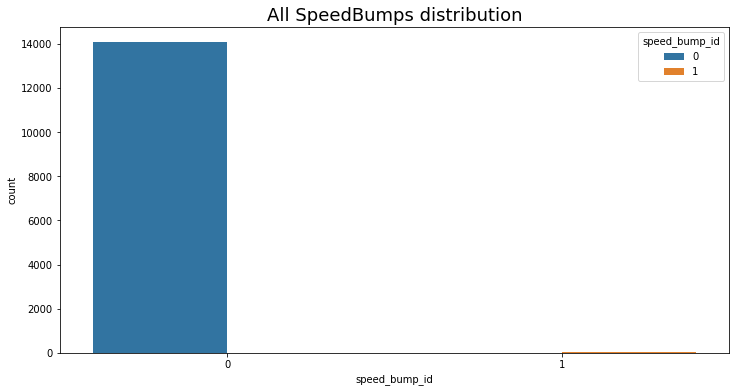

In [48]:
plt.figure(figsize=(12,6))
sns.countplot(x=df['speed_bump_id'], hue=df['speed_bump_id'], data=df).set_title('All SpeedBumps distribution', fontsize=18)

Text(0.5, 1.0, 'SpeedBump vs. Accelerometer Axis Z')

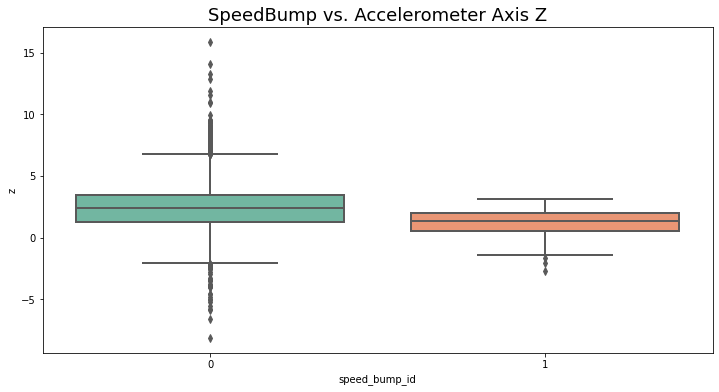

In [49]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['speed_bump_id'], y=df['z'], linewidth=2.0, palette="Set2").set_title('SpeedBump vs. Accelerometer Axis Z', fontsize=18)

Text(0.5, 1.0, 'SpeedBump vs. Accelerometer Axis Y')

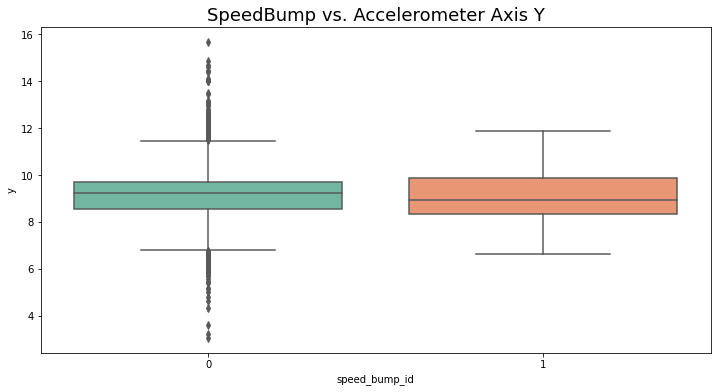

In [50]:
plt.figure(figsize=(12,6))
sns.boxplot(df['speed_bump_id'],df['y'], order=[0, 1], palette="Set2").set_title('SpeedBump vs. Accelerometer Axis Y', fontsize=18)

Text(0.5, 0.98, 'Accelerometer Axis Z')

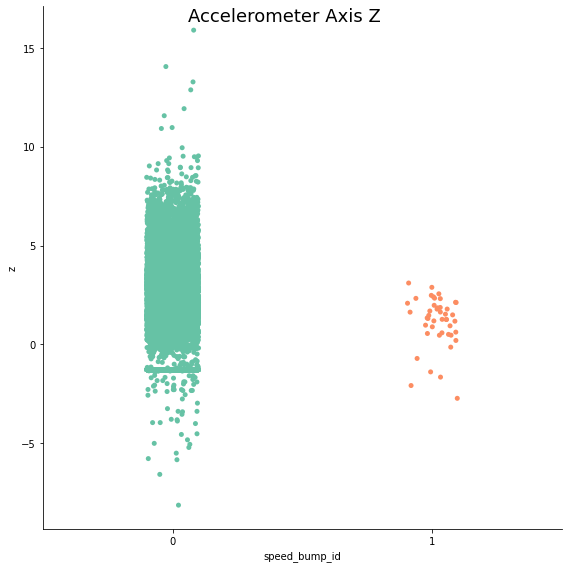

In [51]:
sns.catplot(x='speed_bump_id', y='z', data=df, hue='speed_bump_id', height=8, legend_out=False, palette='Set2').fig.suptitle("Accelerometer Axis Z", fontsize=18)

Text(0.5, 0.98, 'Accelerometer Axis Y')

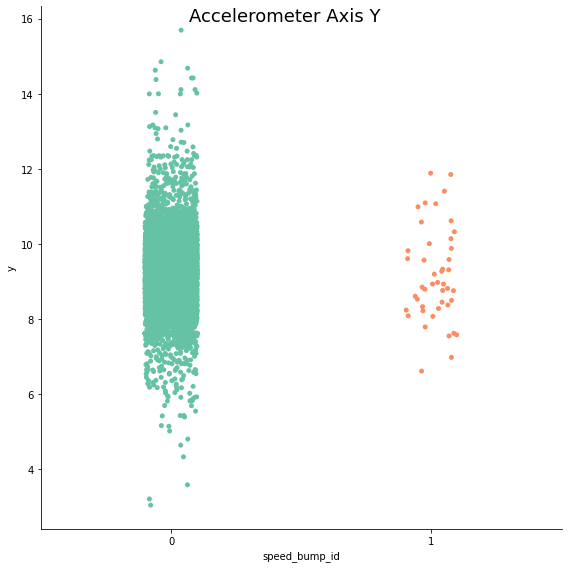

In [52]:
sns.catplot(x='speed_bump_id', y='y', data=df, hue='speed_bump_id', height=8, legend_out=False, palette="Set2").fig.suptitle("Accelerometer Axis Y", fontsize=18)

In [53]:
mapping_speed_bump_timestamps = get_speed_bump_window_distribution(df, mapping_window_width=(5000, 3000), mapping_window_freq='milliseconds', speed_bump_id=1)

In [54]:
df

speed_bump_id          y         z        lat  \
timestamp                                                                
2020-05-17 20:10:49.400              0   9.188202  1.528488 -22.921991   
2020-05-17 20:10:49.500              0   9.188202  1.528488 -22.921991   
2020-05-17 20:10:49.600              0   9.365372  2.237167 -22.921991   
2020-05-17 20:10:49.700              0   9.365372  2.237167 -22.921991   
2020-05-17 20:10:49.800              0   9.743652  1.281876 -22.921991   
...                                ...        ...       ...        ...   
2020-05-17 20:35:51.100              0   9.250443  1.770294 -22.925816   
2020-05-17 20:35:51.200              0  10.105179  1.660172 -22.925816   
2020-05-17 20:35:51.300              0   9.920822  2.608276 -22.925816   
2020-05-17 20:35:51.400              0   9.523392  2.505325 -22.925816   
2020-05-17 20:35:51.500              0   8.999054  2.871628 -22.925816   

                               lng  region_id  z-mean_10  z-std_10  z-diff_5  \
timestamp                                                                      
2020-05-17 20:10:49.400 -42.473372          1   1.335992  0.416962 -0.320816   
2020-05-17 20:10:49.500 -42.473372          1   1.331444  0.414317  1.005569   
2020-05-17 20:10:49.600 -42.473372          1   1.426015  0.502685  1.448486   
2020-05-17 20:10:49.700 -42.473372          1   1.520586  0.560224  0.986404   
2020-05-17 20:10:49.800 -42.473372          1   1.468152  0.555034 -0.174789   
...                            ...        ...        ...       ...       ...   
2020-05-17 20:35:51.100 -42.484631          1   2.505797  1.961719  1.826767   
2020-05-17 20:35:51.200 -42.484631          1   2.415536  1.979490 -4.141968   
2020-05-17 20:35:51.300 -42.484631          1   2.420087  1.979918 -3.193863   
2020-05-17 20:35:51.400 -42.484631          1   2.375316  1.971573  1.259354   
2020-05-17 20:35:51.500 -42.484631          1   2.597977  1.877957  1.101334   

                         z-diff_10    z-norm  
timestamp                                     
2020-05-17 20:10:49.400  -0.045486  0.461662  
2020-05-17 20:10:49.500  -0.045486  0.475588  
2020-05-17 20:10:49.600   0.945709  1.613640  
2020-05-17 20:10:49.700   0.945709  1.279099  
2020-05-17 20:10:49.800  -0.524338 -0.335612  
...                            ...       ...  
2020-05-17 20:35:51.100  -0.660797 -0.374928  
2020-05-17 20:35:51.200  -0.902603 -0.381596  
2020-05-17 20:35:51.300   0.045502  0.095049  
2020-05-17 20:35:51.400  -0.447708  0.065942  
2020-05-17 20:35:51.500   2.226608  0.145717  

[14113 rows x 11 columns]

Shape: (249, 11)


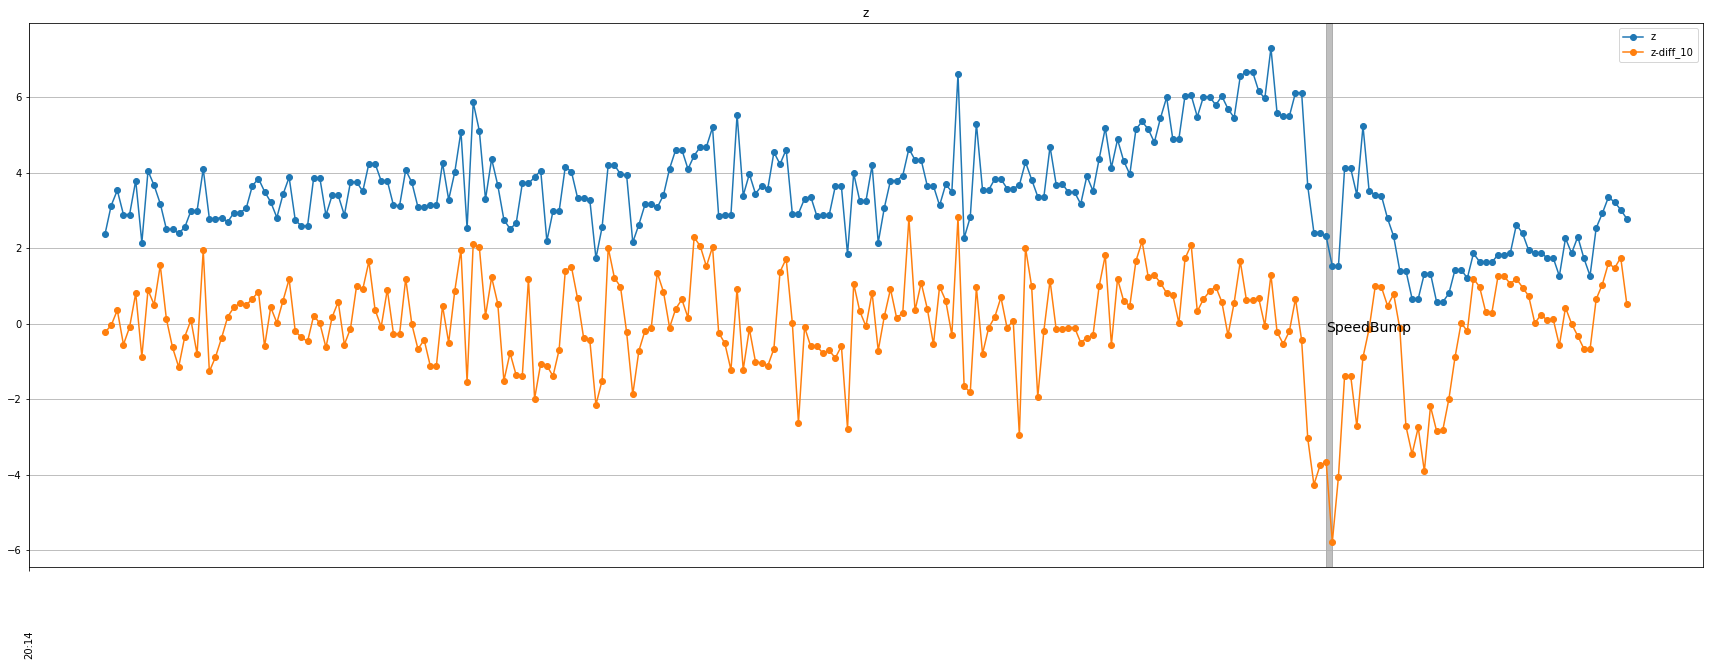

Shape: (249, 11)


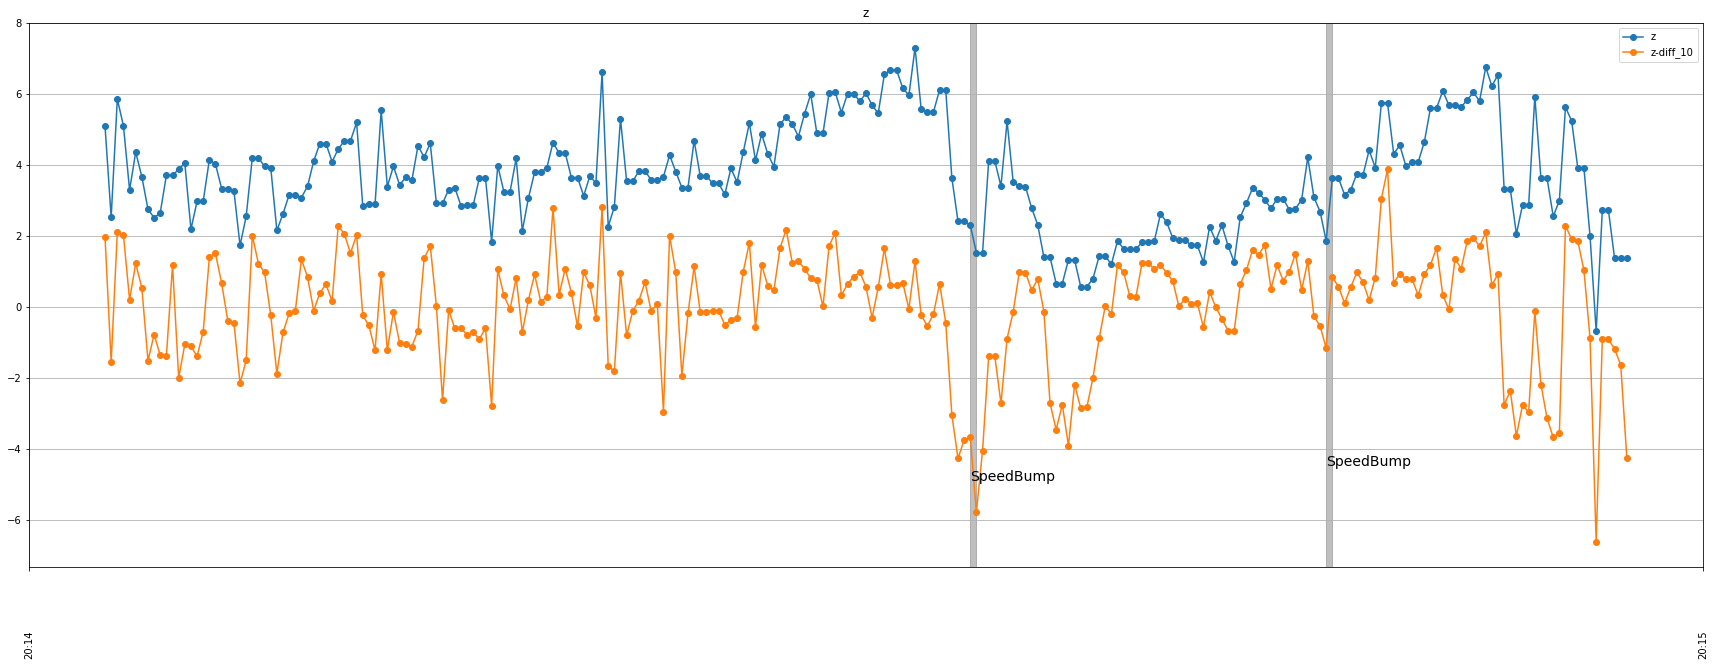

Shape: (249, 11)


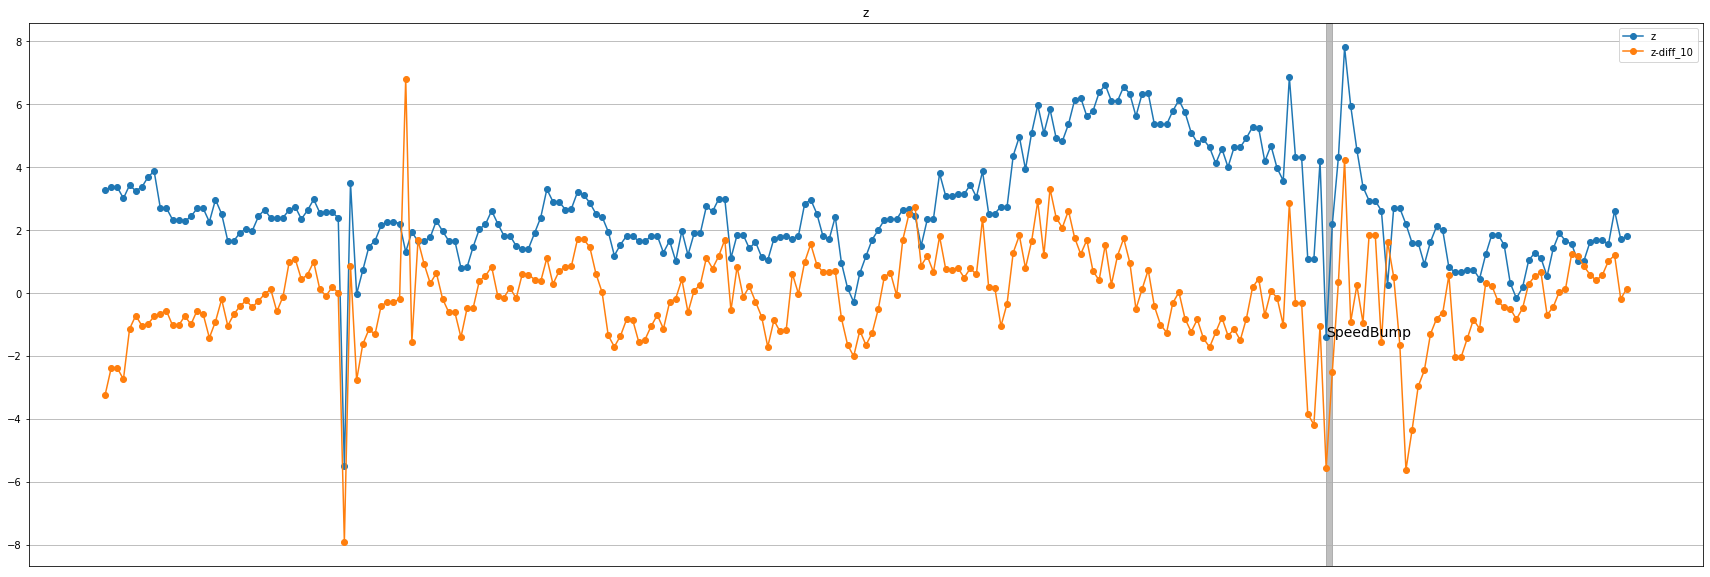

Shape: (249, 11)


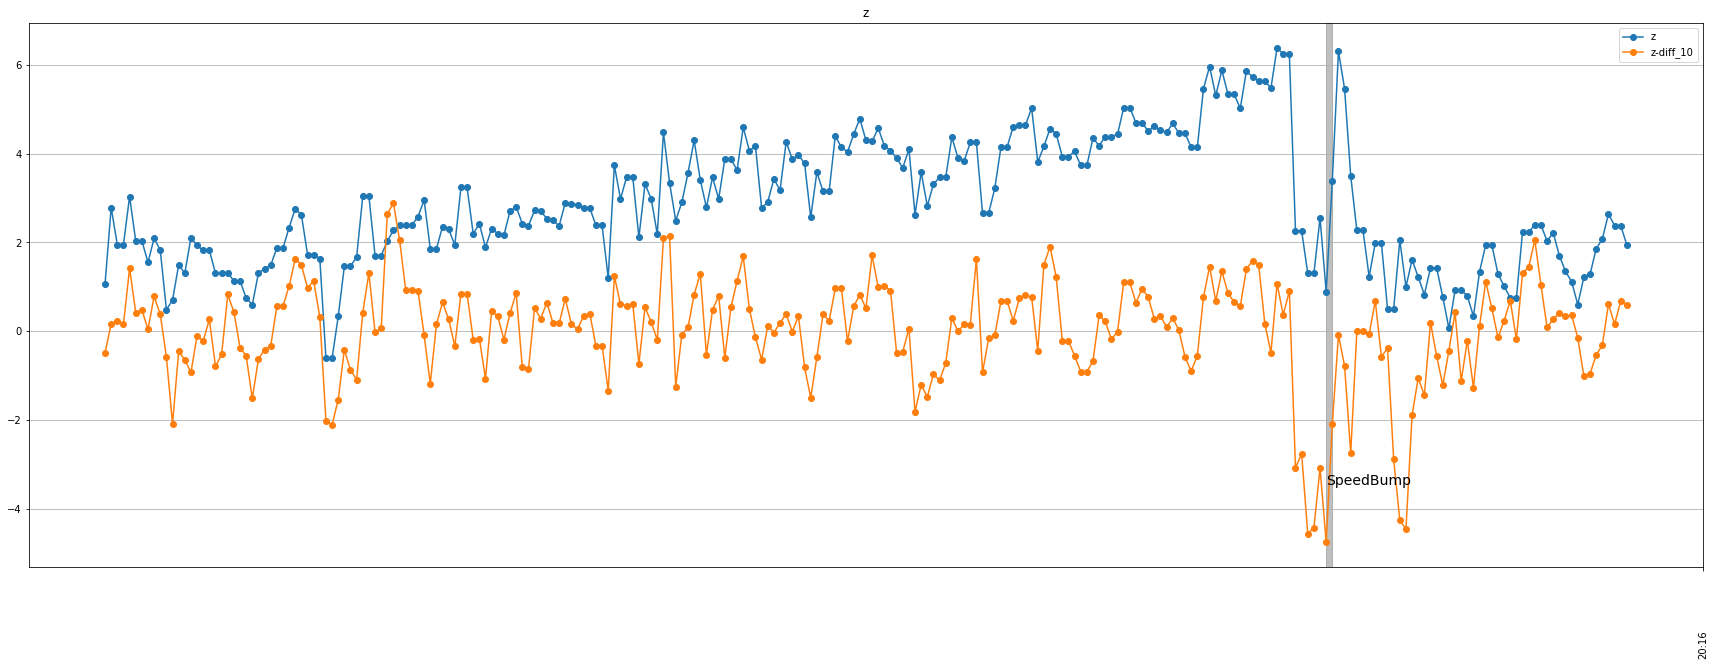

Shape: (249, 11)


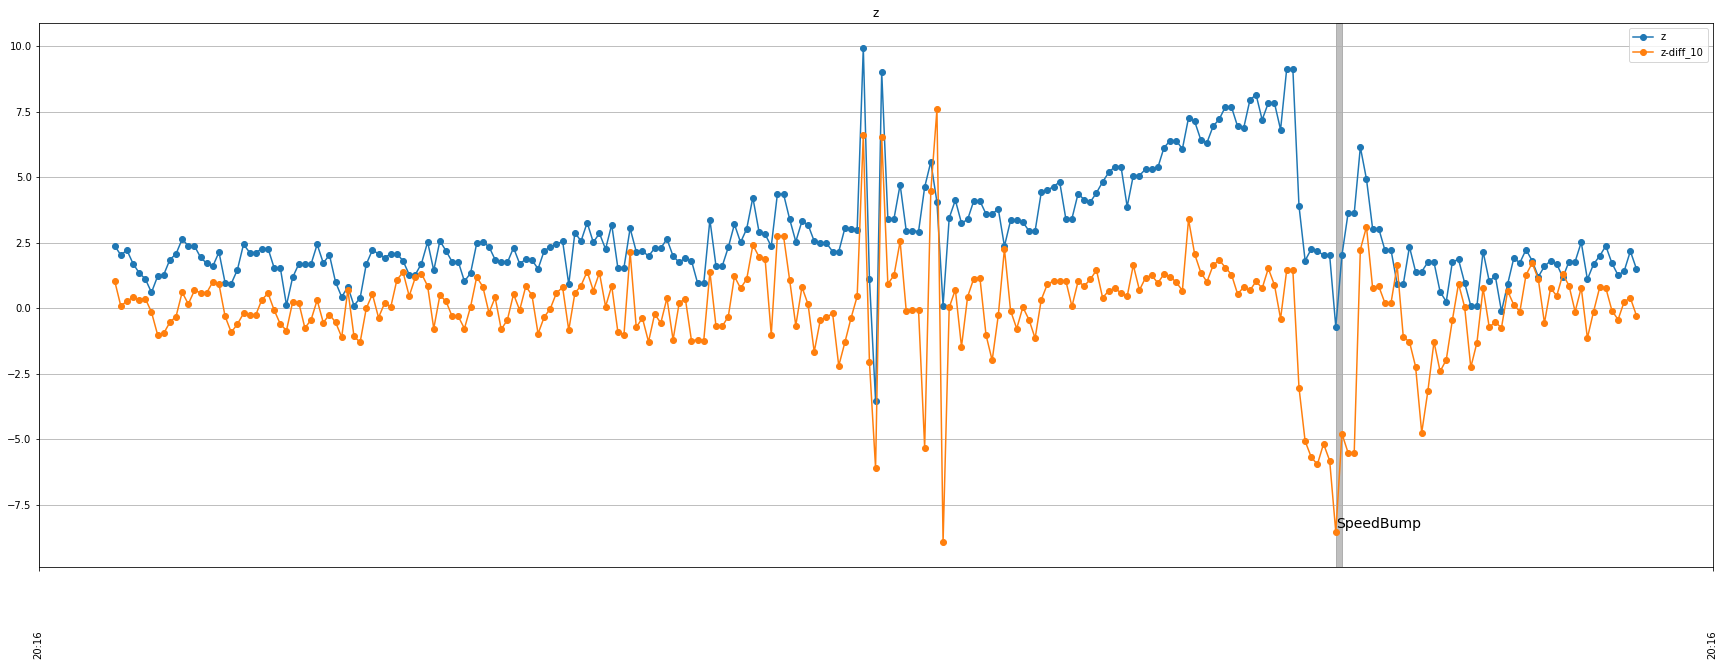

Shape: (249, 11)


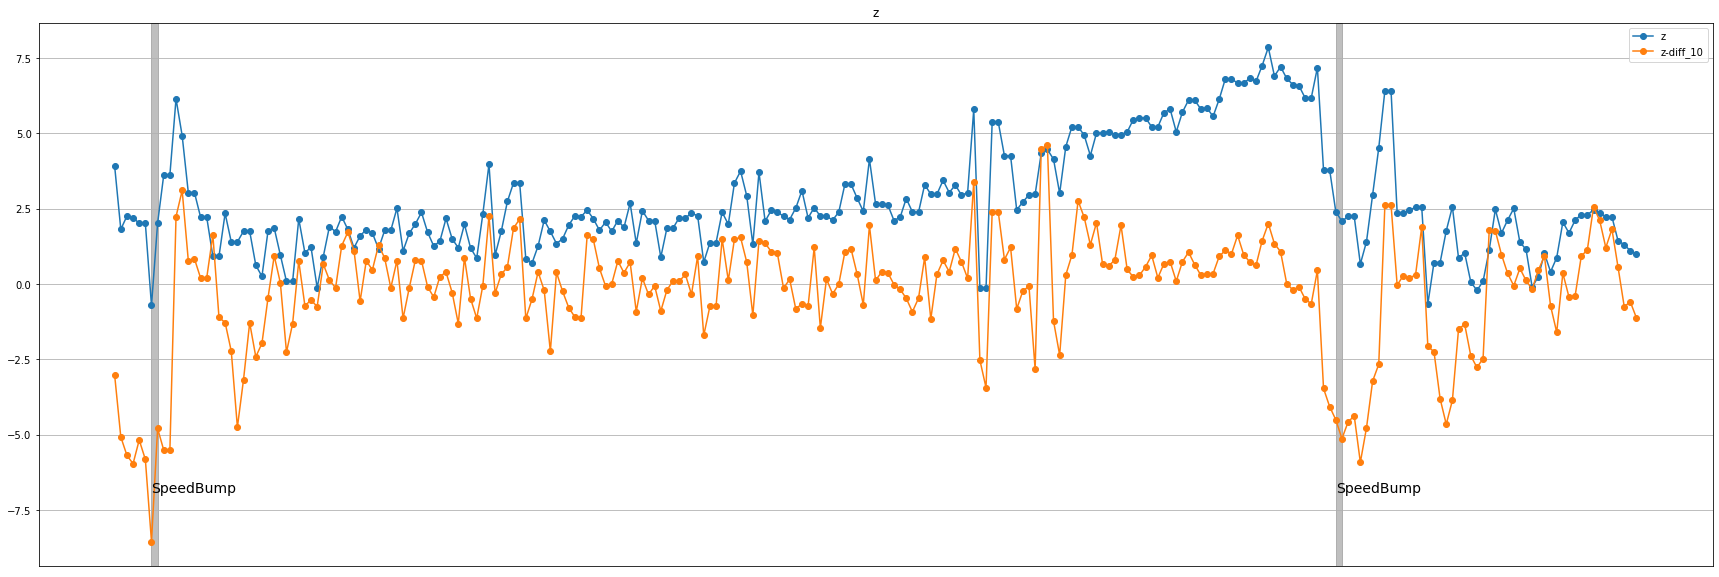

Shape: (249, 11)


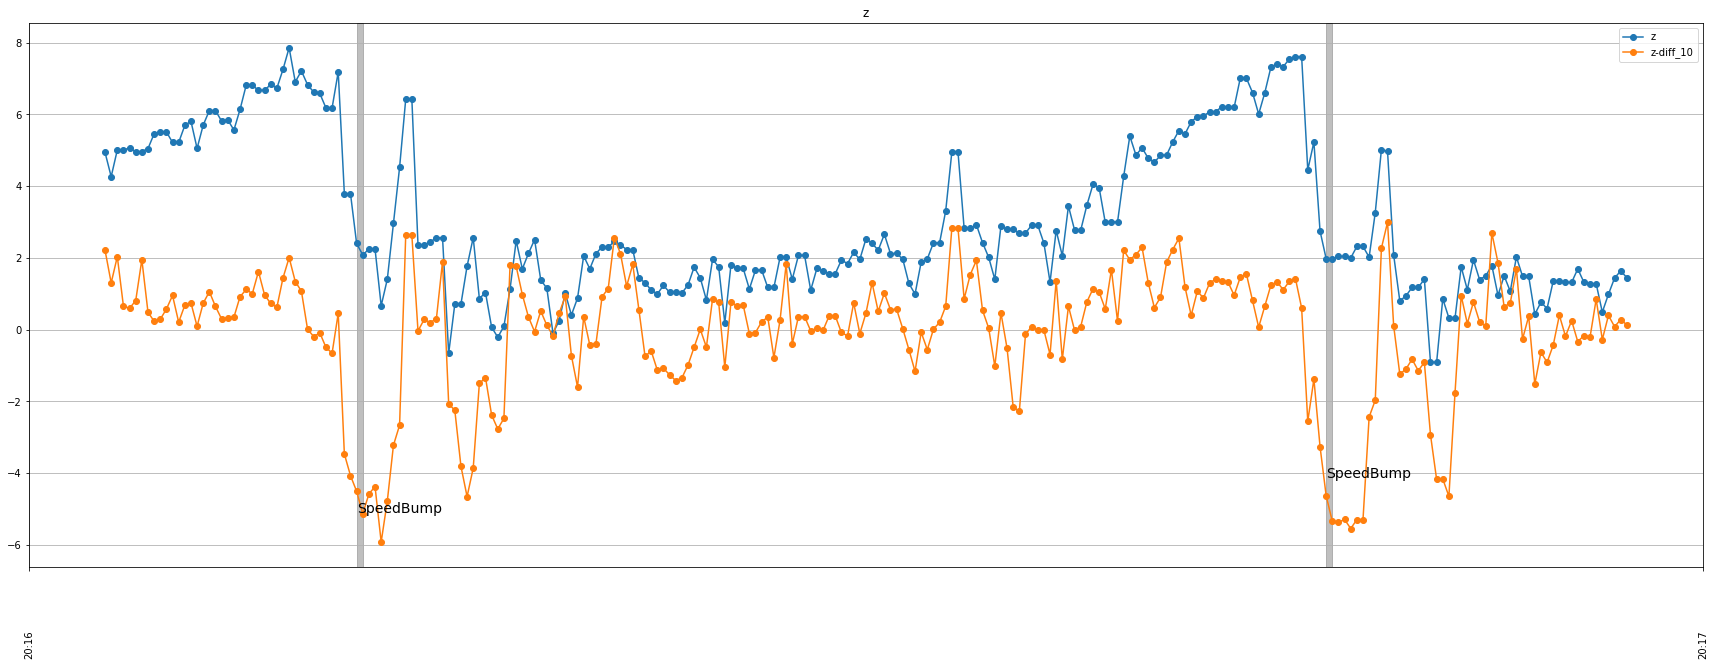

Shape: (249, 11)


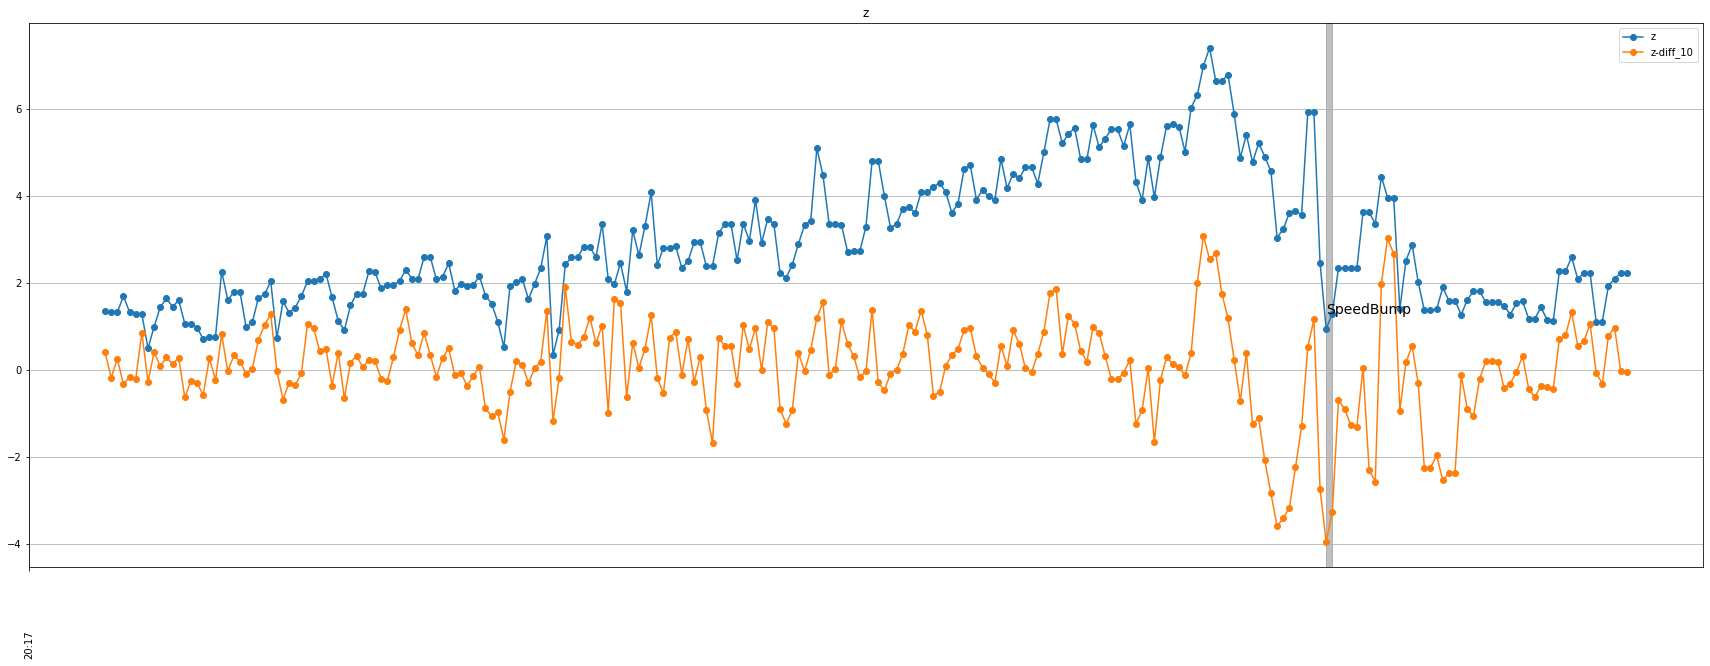

Shape: (249, 11)


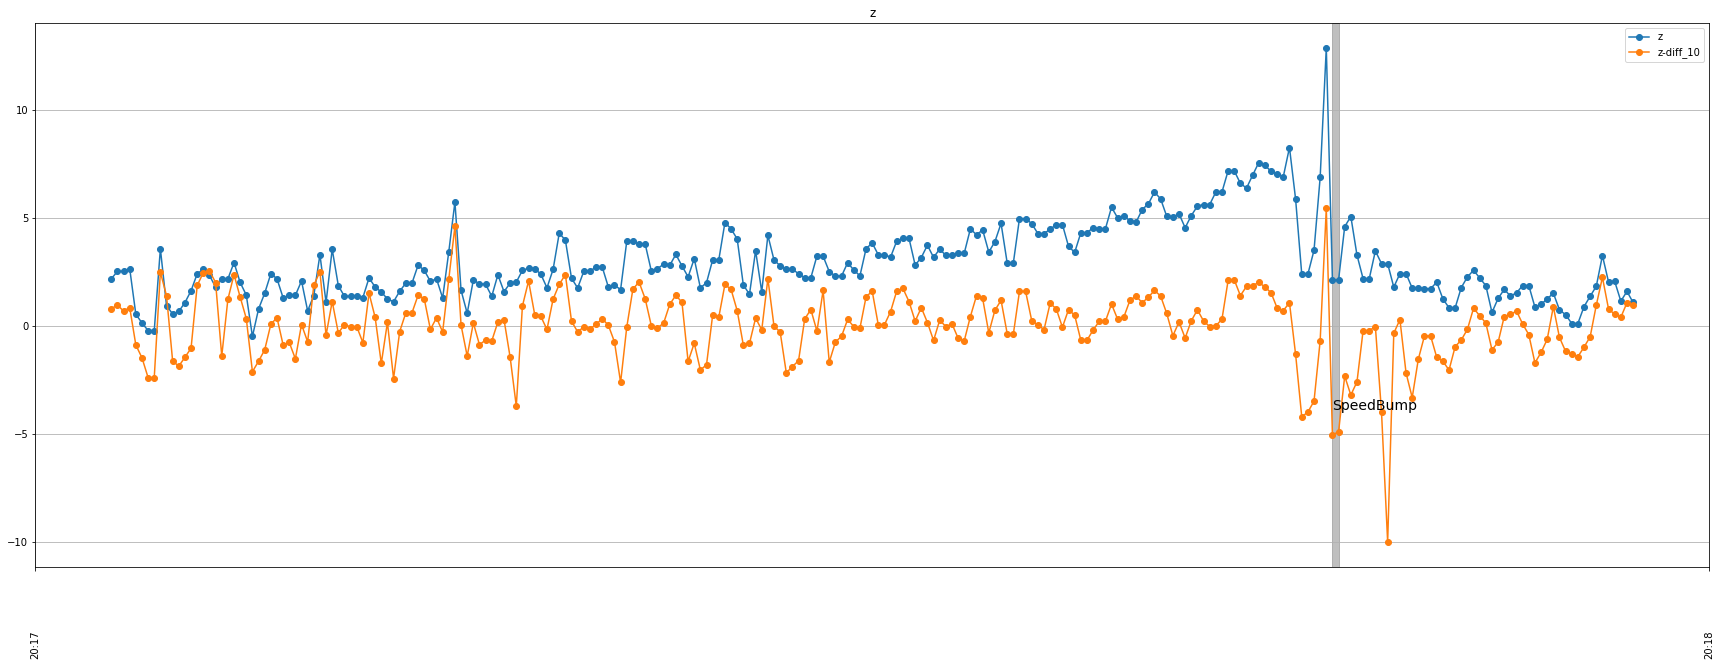

Shape: (249, 11)


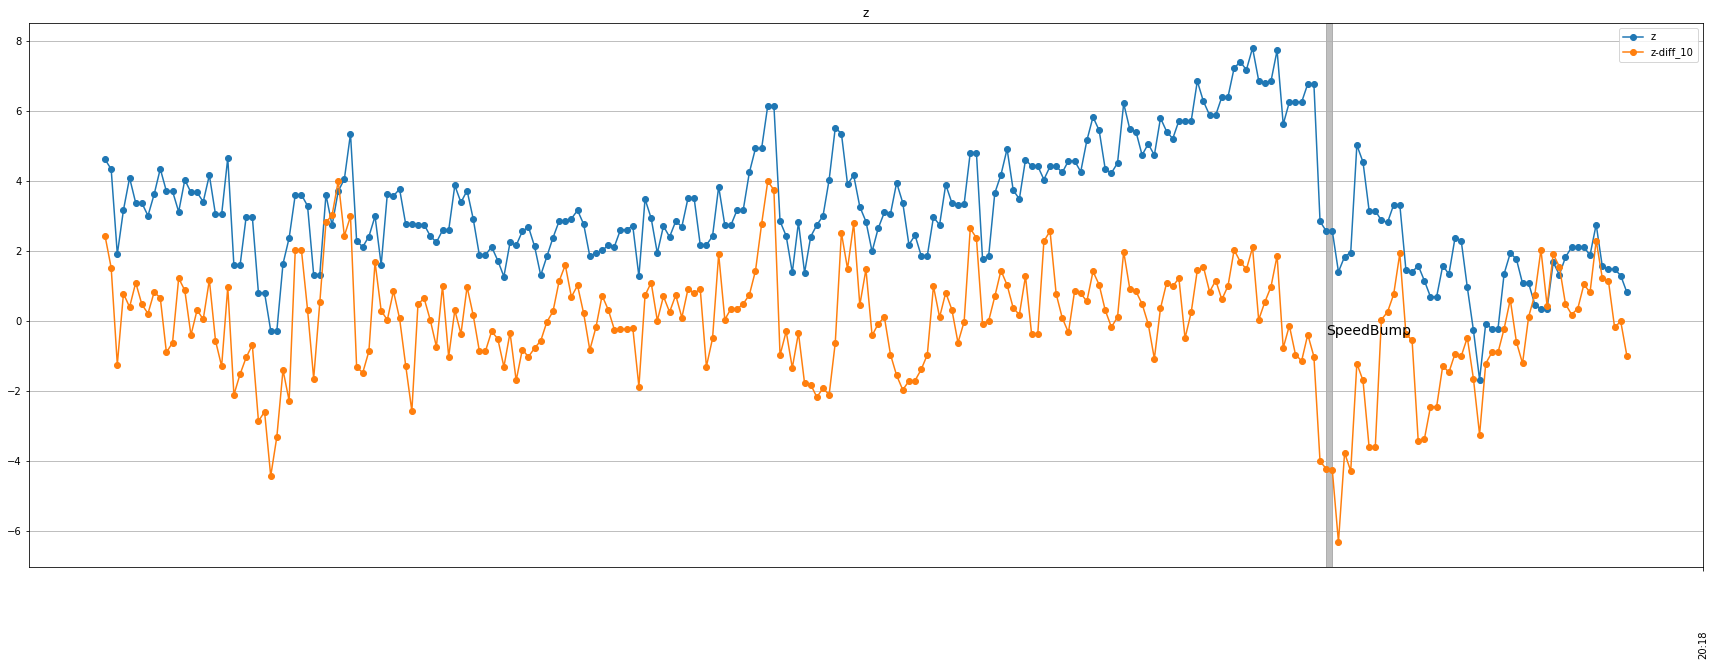

In [55]:
plot_speed_bump_distribution(df, mapping_speed_bump_timestamps, speed_bump_id=1, columns=['z', 'z-diff_10'], backward_time=20, forward_time=5, limit=10)

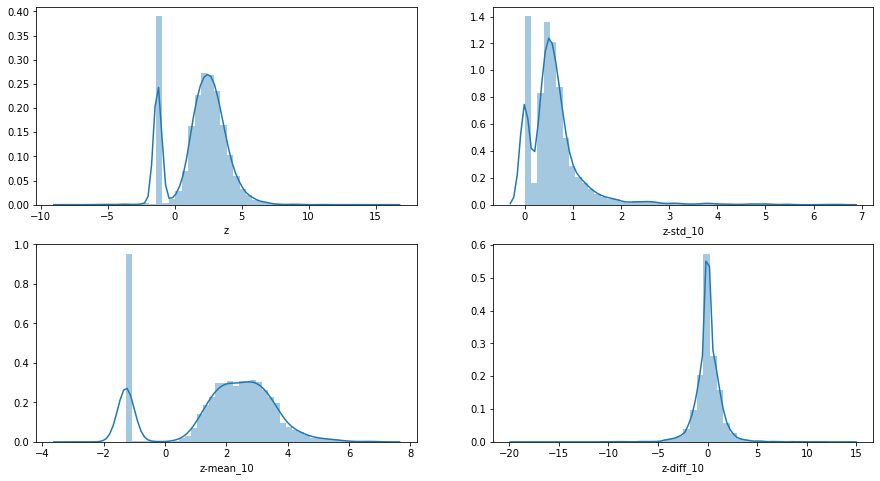

In [63]:
distplot(df, ['z', 'z-std_10','z-mean_10', 'z-diff_10'], region_id=1, ncols=2, nrows=2)

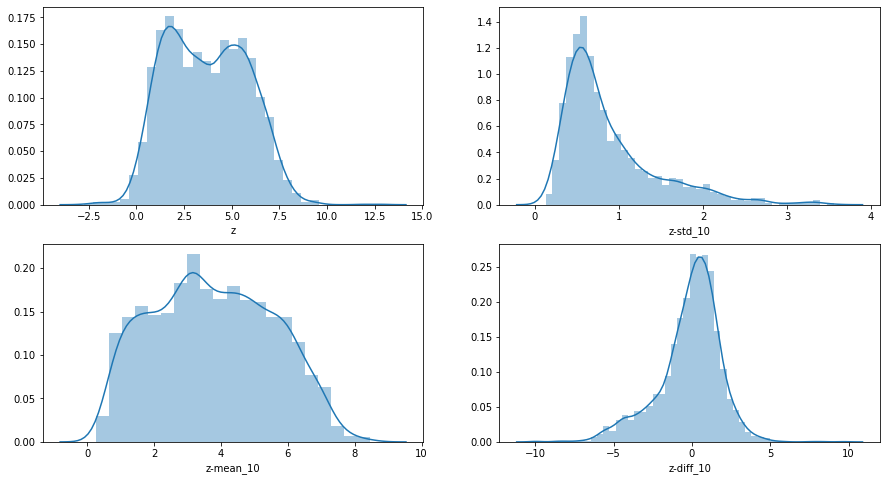

In [65]:
distplot(df, ['z', 'z-std_10', 'z-mean_10', 'z-diff_10'], region_id=2, ncols=2, nrows=2)

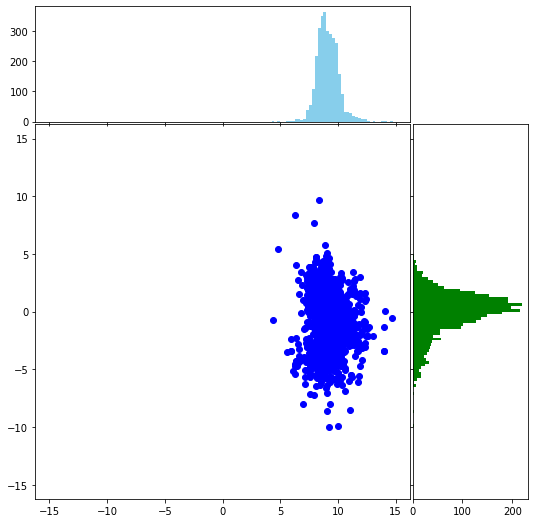

In [76]:
_df = df[df.region_id == 2]
scatter_hist(_df['y'], _df['z-diff_10'])

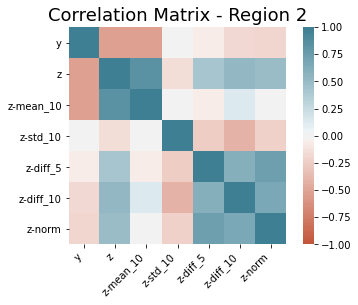

In [88]:
corr = _df[df.region_id == 2][['y','z','z-mean_10','z-std_10','z-diff_5','z-diff_10','z-norm']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

ax.set_title('Correlation Matrix - Region 2', fontsize=18)
plt.show()

In [283]:
all_timestamps=[]
for sb_id in mapping_speed_bump_timestamps:
    for sb_t in mapping_speed_bump_timestamps[sb_id]:
        all_timestamps.extend(list(mapping_speed_bump_timestamps[sb_id].values()))

all_timestamps = list(set(all_timestamps))

In [284]:
df3 = tukey_method(df, ignore_on_timestamps=all_timestamps, columns=['z'], q1=0.35, q3=0.65)

#df.loc[df.timestamp.isin(df2.timestamp), 'y'] = df2.y


Removing outliers by tukey method:
Size reduction: 14 969 → 11 258 | 75.21% of original size


In [287]:
_df = df.copy()

In [288]:
_df.reset_index(inplace=True)
_df = _df.loc[_df.timestamp.isin(df3.timestamp)]
_df.set_index('timestamp', inplace=True)

In [289]:
_df.shape

(11258, 11)

In [290]:
def tukey_method(df0, ignore_on_timestamps, columns, q1=0.25, q3=0.75, drop = True):
    ''' 
    Função que remove outliers de acordo com o método de Tukey
    -----------------------------------------------------------------------------
    Calculam-se os quantils Q1 e Q3, e o intervalo interquartil IQR=Q3-Q1
    São considerados como outliers todos os valores fora do intervalo [Q1-1.5*IQR ; Q3+1.5*IQR]
    -----------------------------------------------------------------------------
    Parâmetros :        
    
        df0::pandas.DataFrame
            DataFrame com o conjunto de dados a ser filtrado
        columns::list
            Lista com o nome de todas as colunas nas quais se deseja aplicar o método
        q1::float
            Valor do primeiro quantil usado no método. Default é Q1 = 25%
        q3::float
            Valor do terceiro quantil usado no método. Default é Q3 = 75%
        Drop::Bool
            Bool que indica se a função remove os outliers, ou substitue estes por Nan. Default = True
    
    Retorno :
        Um novo DataFrame sem os outliers
    -----------------------------------------------------------------------------  
    Exemplo : 
        df = tukey_method(df0, ['TAG1','TAG2','TAG3'])
            
    '''
    df=df0.copy()
    
    df.drop(ignore_on_timestamps, axis=0,errors='ignore', inplace=True)
    df.reset_index(inplace=True)

    size1 = df.shape[0]    
    for col in columns:
        Q1 = df[col].quantile(q1)                 
        Q3 = df[col].quantile(q3)
        iqr = 1.5*(Q3-Q1)
        if drop:
            df = df[(df[col] < Q3+iqr) & (df[col]>Q1-iqr)]
        else:
            df.loc[(df[col] > Q3+iqr),col]=np.nan
            df.loc[(df[col] < Q1-iqr),col]=np.nan
    if drop:
        size2 = df.shape[0]
        print('Removing outliers by tukey method:')
        print (f'Size reduction: {size1:,} → {size2:,} | {size2/size1*100:.2f}% of original size'.replace(',',' '))
    return df


In [291]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [292]:
_df2 = series_to_supervised(list(df.z.values), n_in=20, n_out=10, dropnan=True)

In [293]:
_df2

var1(t-20)  var1(t-19)  var1(t-18)  var1(t-17)  var1(t-16)  var1(t-15)  \
20       1.528488    1.528488    2.237167    2.237167    1.281876    0.714462   
21       1.528488    2.237167    2.237167    1.281876    0.714462    1.451874   
22       2.237167    2.237167    1.281876    0.714462    1.451874    4.710373   
23       2.237167    1.281876    0.714462    1.451874    4.710373   -5.053177   
24       1.281876    0.714462    1.451874    4.710373   -5.053177   -2.141830   
...           ...         ...         ...         ...         ...         ...   
15008    1.286667    0.573196    0.987396    1.751144    1.614670    1.614670   
15009    0.573196    0.987396    1.751144    1.614670    1.614670    3.228363   
15010    0.987396    1.751144    1.614670    1.614670    3.228363    4.672073   
15011    1.751144    1.614670    1.614670    3.228363    4.672073   -0.401245   
15012    1.614670    1.614670    3.228363    4.672073   -0.401245    2.107880   

       var1(t-14)  var1(t-13)  var1(t-12)  var1(t-11)  ...   var1(t)  \
20       1.451874    4.710373   -5.053177   -2.141830  ... -3.384415   
21       4.710373   -5.053177   -2.141830   15.888901  ...  0.479828   
22      -5.053177   -2.141830   15.888901   -8.127335  ...  0.479828   
23      -2.141830   15.888901   -8.127335   -0.556870  ... -5.831299   
24      15.888901   -8.127335   -0.556870   -2.287872  ...  2.524475   
...           ...         ...         ...         ...  ...       ...   
15008    3.228363    4.672073   -0.401245    2.107880  ...  2.562775   
15009    4.672073   -0.401245    2.107880    2.826141  ...  2.562775   
15010   -0.401245    2.107880    2.826141    2.751923  ...  2.953033   
15011    2.107880    2.826141    2.751923    2.912338  ...  0.645020   
15012    2.826141    2.751923    2.912338    2.792618  ... -0.056473   

       var1(t+1)  var1(t+2)  var1(t+3)  var1(t+4)  var1(t+5)  var1(t+6)  \
20      0.479828   0.479828  -5.831299   2.524475  -4.519272   1.064011   
21      0.479828  -5.831299   2.524475  -4.519272   1.064011   1.413559   
22     -5.831299   2.524475  -4.519272   1.064011   1.413559  -3.875229   
23      2.524475  -4.519272   1.064011   1.413559  -3.875229   1.870850   
24     -4.519272   1.064011   1.413559  -3.875229   1.870850  -2.759537   
...          ...        ...        ...        ...        ...        ...   
15008   2.562775   2.953033   0.645020  -0.056473   5.802139   5.802139   
15009   2.953033   0.645020  -0.056473   5.802139   5.802139   1.245972   
15010   0.645020  -0.056473   5.802139   5.802139   1.245972   1.770294   
15011  -0.056473   5.802139   5.802139   1.245972   1.770294   1.770294   
15012   5.802139   5.802139   1.245972   1.770294   1.770294   1.660172   

       var1(t+7)  var1(t+8)  var1(t+9)  
20      1.413559  -3.875229   1.870850  
21     -3.875229   1.870850  -2.759537  
22      1.870850  -2.759537  -0.190552  
23     -2.759537  -0.190552  -0.846558  
24     -0.190552  -0.846558   0.661789  
...          ...        ...        ...  
15008   1.245972   1.770294   1.770294  
15009   1.770294   1.770294   1.660172  
15010   1.770294   1.660172   2.608276  
15011   1.660172   2.608276   2.505325  
15012   2.608276   2.505325   2.871628  

[14993 rows x 30 columns]

In [294]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(_df['var1(t-20)'], _df['var1(t-3)'], ax, ax_histx, ax_histy)

plt.show()

KeyError: 'var1(t-20)'